### 1. American Sign Language (ASL)
<img src="https://upload.wikimedia.org/wikipedia/commons/7/7d/American_Sign_Language_ASL.svg" alt='"ASL" spelled out in American Sign Language fingerspelling' style="width: 600px;"/>

Dataset used from N. Pugeault, University of Surrey

Original code : https://www.kaggle.com/gargimaheshwari/asl-recognition-with-deep-learning

Changes made by Loïc Baum 

In [1]:
import numpy as np
np.random.seed(5) 
import keras
import tensorflow as tf
tf.random.set_seed(2)

import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2


data_dir = "./asl-surrey-black-padding"

Using TensorFlow backend.


### 2. Loading the data

In [2]:
img_size = 64,64

#Helper function to load images from given directories
def load_images(directory):
    images = []
    labels = []
    print("Loading Data : ")
    for idx, label in enumerate(uniq_labels):
        print("|",label,"|",end="")
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.imread(filepath)
            # image = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5) #test
            images.append(image) 
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)


uniq_labels = sorted(os.listdir(data_dir))
images, labels = load_images(directory = data_dir)


Loading Data : 
| A || B || C || D || E || F || G || H || I || K || L || M || N || O || P || Q || R || S || T || U || V || W || X || Y |

Splitting the Dataset into 3 Subsets : Training (80%), Validation (10%) and Test (10%)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(images, labels, test_size = 0.20, stratify = labels)
X_eval, X_test, y_eval, y_test = train_test_split(X_eval, y_eval, test_size = 0.50, stratify = y_eval)

n = len(uniq_labels)
train_n = len(X_train)
eval_n = len(X_eval)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of eval images: ", eval_n)

test_n = len(X_test)
print("Number of test images: ", test_n)

Total number of symbols:  24
Number of training images:  53228
Number of eval images:  6653
Number of test images:  6654


We see that we have a total of 24 symbols. These are the letters A to Y, with J and Z excluded

# 3. Printing images

In [4]:
#Helper function to print images
def print_images(image_list):
    n = int(len(image_list) / len(uniq_labels))
    cols = 8
    rows = 4
    fig = plt.figure(figsize = (24, 12))

    for i in range(len(uniq_labels)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_list[int(n*i)])
        plt.title(uniq_labels[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

Sorting the images based on their label

Training Images: 


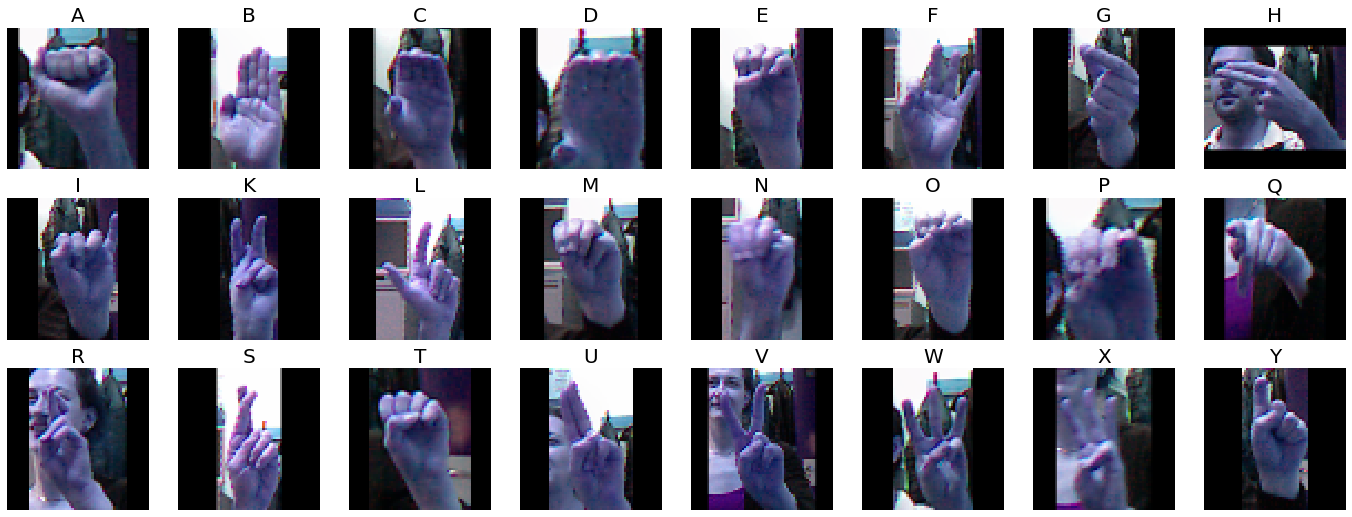

In [5]:
y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]

print("Training Images: ")
print_images(image_list = X_train)


Eval images: 


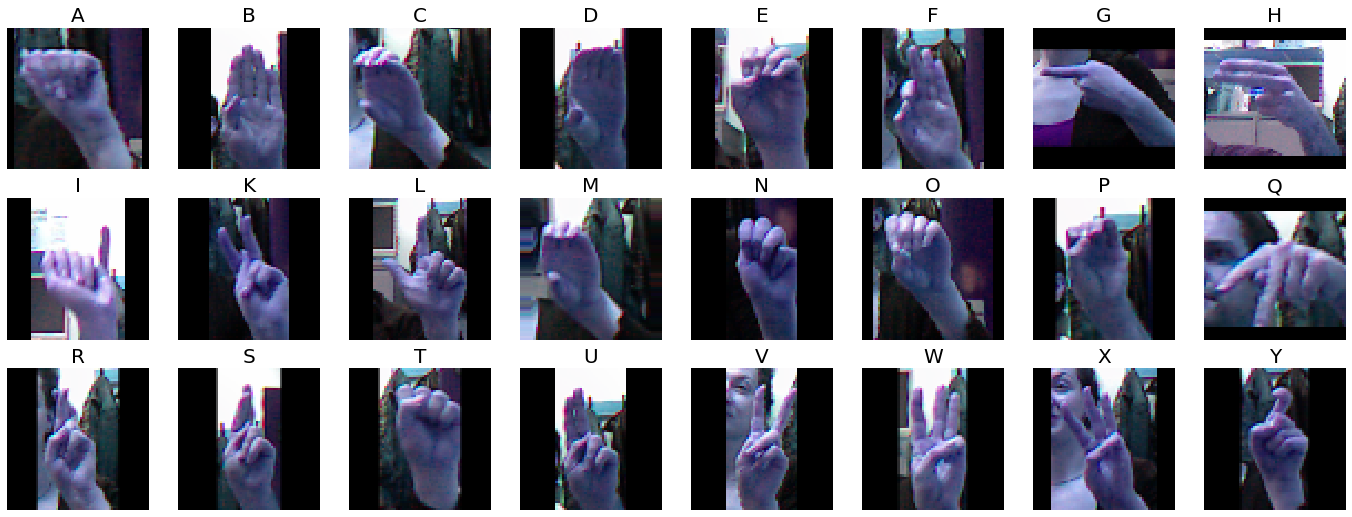

In [6]:
y_eval_in = y_eval.argsort()
y_eval = y_eval[y_eval_in]
X_eval = X_eval[y_eval_in]

print("Eval images: ")
print_images(image_list = X_eval)


test images: 


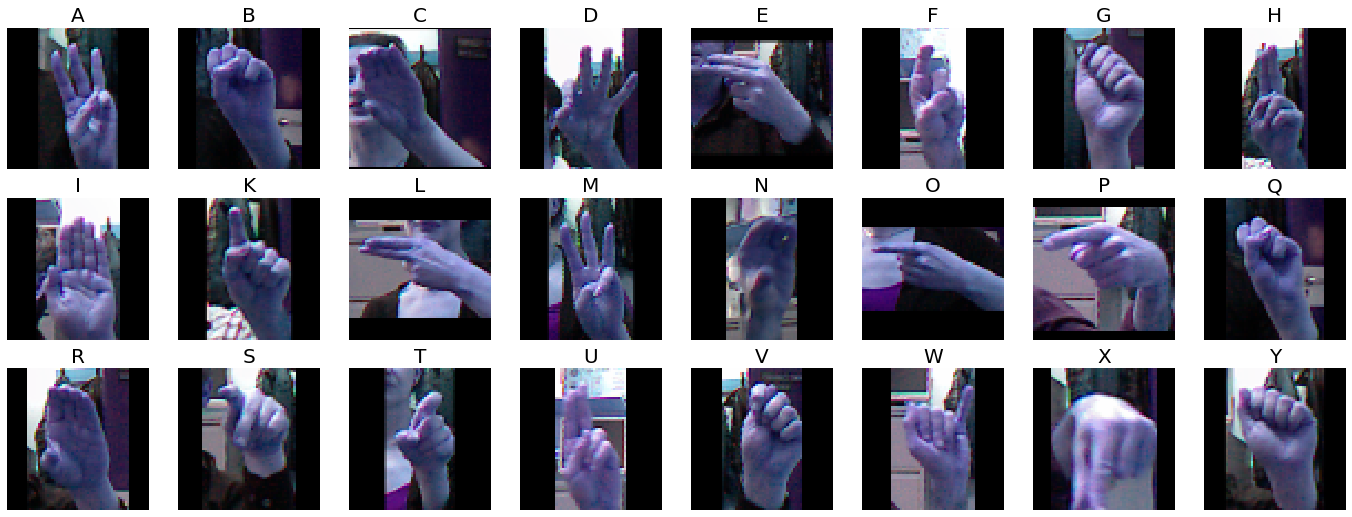

In [7]:
print("test images: ")
print_images(image_list = X_test)

### 4. Preprocessing: One-hot enconding the data

In [8]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

### 5. Preprocessing - Normalize RGB values

In [9]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

### 6. Define and run the model

In [10]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import load_model

#Loading model saved on disk
def load_model_from_disk(MODEL_PATH, MODEL_WEIGHTS_PATH):
    '''A convenience method for re-running certain parts of the
    analysis locally without refitting all the data.'''   
    print('Retrieving model from disk...')
    model = load_model(MODEL_PATH)           
    print('Loading CNN model weights from disk...')
    model.load_weights(MODEL_WEIGHTS_PATH)
    return model

#Building model from scratch
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', 
                     input_shape = (64, 64, 3)))
    model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (4, 4)))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (4, 4)))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(24, activation='softmax'))
    return model

#building model from VGG16
def build_model_VGG():
    base = VGG16(include_top = False, weights='imagenet',input_shape = (64,64,3))
    X = base.output
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.4)(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Dense(512, activation = 'relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    preds = keras.layers.Dense(24, activation = 'softmax')(X)
    model = keras.models.Model(inputs = base.input, outputs = preds)
    return model


#Either build new model or load model from disk

# model = build_model()
model = build_model_VGG()

model_file = "./saved_nets_weights/cnn-model-vgg.h5"  
weights_file = "./saved_nets_weights/cnn-model-vgg.weights.h5"

# model =  load_model_from_disk(model_file,weights_file)
model.summary()


model.compile(optimizer = keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

### 7. Fitting the model

In [11]:
#If model loaded from disk, no need to fit it
hist = model.fit(X_train, y_train, epochs = 10, batch_size = 64, validation_data=(X_eval,y_eval))

Train on 53228 samples, validate on 6653 samples
Epoch 1/10
53228/53228 [==============================] - 237s 4ms/step - loss: 1.5340 - accuracy: 0.5692 - val_loss: 0.1858 - val_accuracy: 0.9507

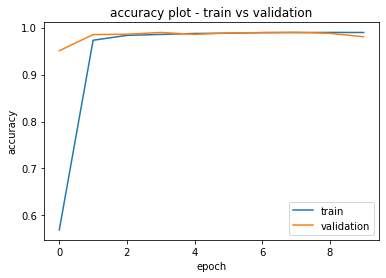

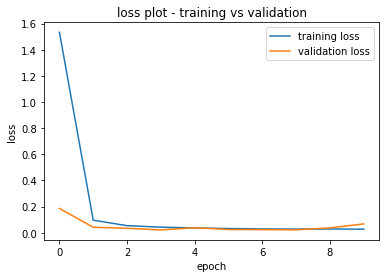

In [12]:
##Plotting Accuracy and loss learning curves
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('accuracy plot - train vs validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('Accuracy_plot_cnn.png')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs validation')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('Loss_plot_cnn.png')
plt.show()




# 7. Test the model

In [13]:
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')

Accuracy for evaluation images: 98.046 %
Accuracy for test images: 97.776 %


# 8. Confusion Matrices

In [14]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

#### Confusion matric of validation data

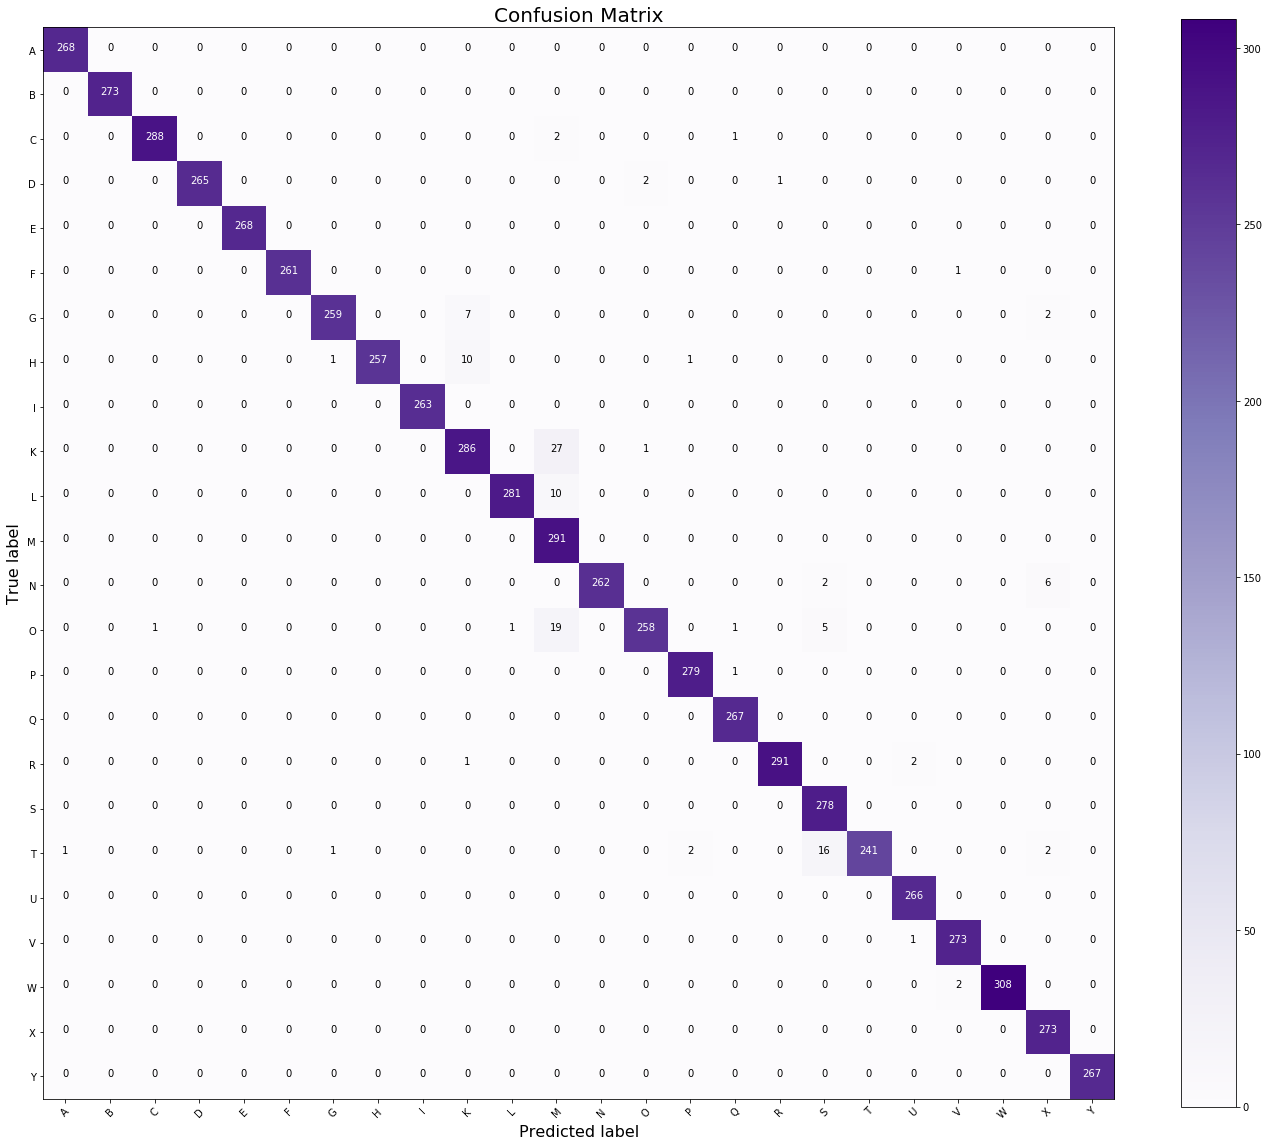

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
y_eval_pred = model.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

#### Confusion matric of test data

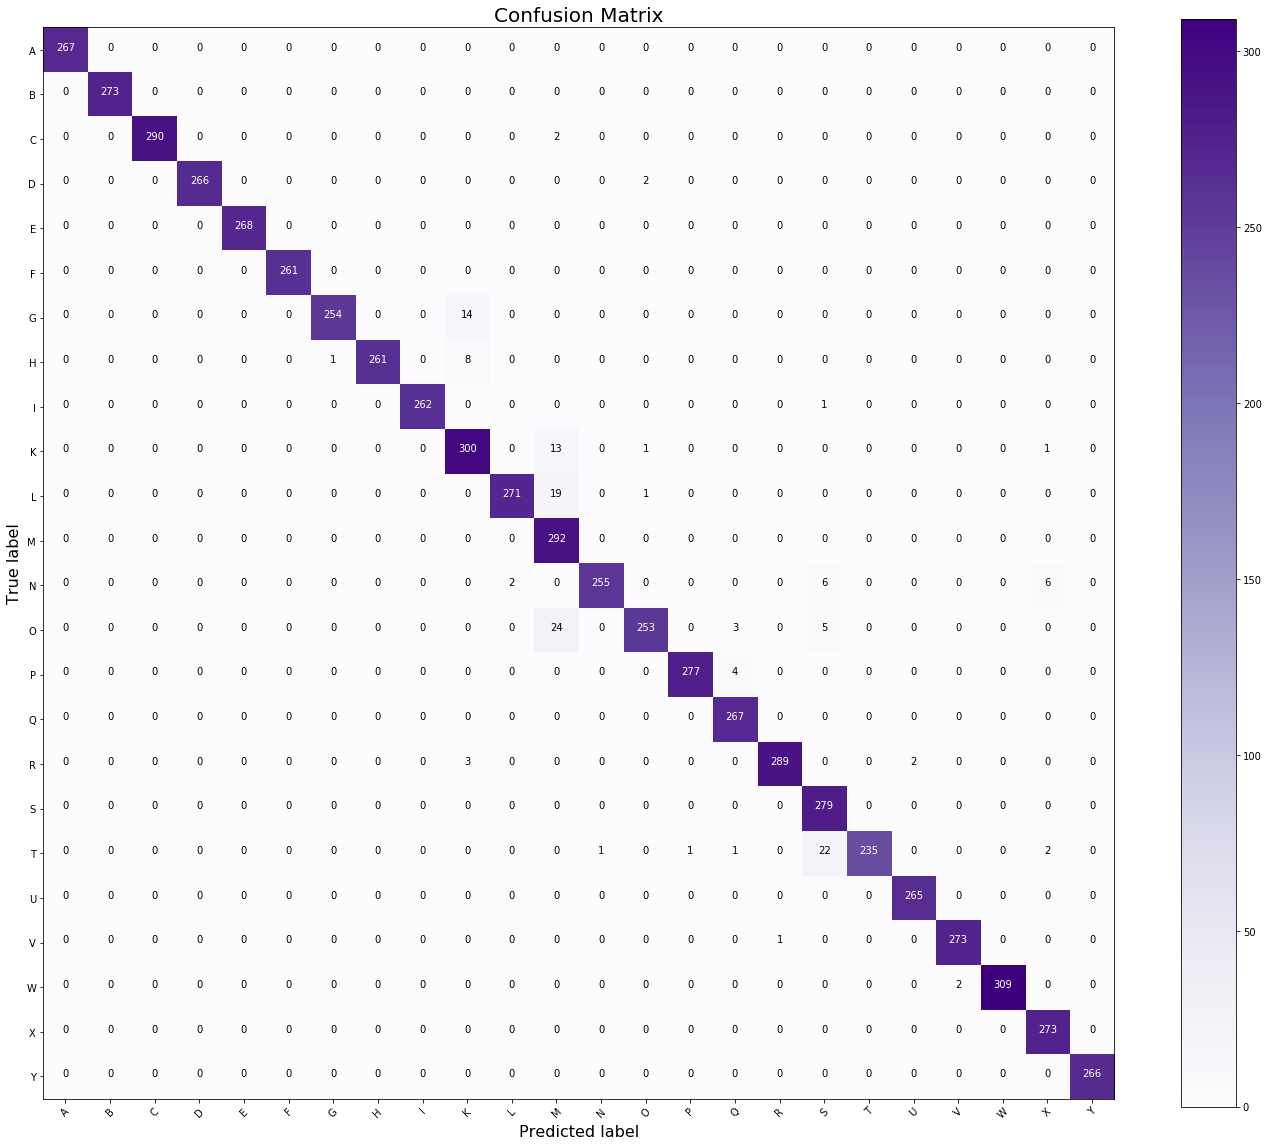

In [16]:
y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

#### Saving model to disk

In [17]:
def save_model_to_disk(model, MODEL_PATH, MODEL_WEIGHTS_PATH):
    model.save(MODEL_PATH)
    model.save_weights(MODEL_WEIGHTS_PATH)
    print("Model and Weights saved !")
    
# save_model_to_disk(model,"./saved_nets_weights/cnn-model-surrey-vgg.h5","./saved_nets_weights/cnn-model-surrey-vgg.weights.h5")
